In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as const
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

In [2]:
# Physical constants
grav_cons=const.G
sun_m=(1.989)*10**30        # Mass of the sun in kg 
earth_radius=(6371)*10**3        # Radius of the earth in m 

filename = 'white_dwarf_data.csv'

In [3]:
def data_process(filename):
        # Process the data and convert columns into numpy arrays. Returns logg and mass columns.
        data = pd.read_csv(filename)
        logg = data.loc[:,"logg"].to_numpy()
        mass = data.loc[:,"mass"].to_numpy()

        return logg, mass

In [4]:
def filter_mass(R, threshold):
    # Filters mass and corresponding logg values based on a threshold for mass we select.
    # Apply the threshold filter
    logg, mass = data_process(filename)
    mask = mass <= threshold    # Low mass filter
    mask_large = mass > threshold   # Large mass filter

    low_mass = mass[mask]
    low_R= R[mask]

    large_mass = mass[mask_large]
    large_R= R[mask_large]

    return low_R, low_mass, large_R, large_mass

In [5]:
def le_solver(nstar, xi_f=20):
    # le_solver solves and returns solutions of the Lane-Emden Equation numerically with built-in solve_ivp method.
    # n is the parameter in LE equation where xi_f is the final xi value of integration 

    # Initial value of y
    yinit = np.asarray([1, 0]).astype(float)

    # RHS of LE equation
    def f(t, y):
        # Initialize as zero vector
        f = np.zeros(len(y)) 

        f[0] = y[1]
        if t==0:
            f[1] = 0
        else:
            f[1] = -np.float_power(y[0], nstar) - (2/t) * y[1]
        return f


    sol = solve_ivp(fun=f, t_span=(0, xi_f), y0=yinit, max_step = 1e-5)
    

    xi = sol.t
    theta = sol.y[0,:]
    theta_prime = sol.y[1,:]


    return xi, theta, theta_prime

In [6]:
def part_b():
    # This function solve part b of the Newton. From the basic newtonian gravity we can derive: r = sqrt(G*M/g) 
    # Plots M vs R 

    logg, mass = data_process(filename)
    g = (10**logg)/100  # Converted to MKS units

    r = np.sqrt(grav_cons * mass * sun_m/g)
    R = r/earth_radius

    return mass, R

In [7]:
def part_c(R):
     # This function solve part c of the Newton. It filters mass based on a threshold, performs a linear fit into the M-R expression 
     # and solves the Lane-Emden equation numerically

    # Threshold for low mass selection
    threshold = 0.4

    # Get the filtered data based on the threshold.
    # low_mass <= 0.4 <-> low_R
    # large_mass > 0.4 <-> large_R
    low_R, low_mass, large_R, large_mass = filter_mass(R, threshold)

    # Log-log transformation for power-law visualization
    low_R_log, low_mass_log = np.log(low_R), np.log(low_mass)
    large_R_log, large_mass_log = np.log(large_R), np.log(large_mass)


    plt.figure(figsize=(10, 6))
    plt.scatter(low_R_log, low_mass_log, label='Below threshold Stars', alpha=0.4)
    plt.scatter(large_R_log, large_mass_log, label='Above threshold Stars', alpha=0.4)
    
    # Now we perform a linear fit in the form: ln(M) = slope * ln(R) + intercept
    slope, intercept = np.polyfit(low_R_log, low_mass_log, 1)

    # Linear fit line
    x_range = np.linspace(np.min(low_R_log), np.max(low_R_log), len(R))
    lin_fit = intercept + slope * x_range

    plt.plot(x_range, lin_fit, color='red', linestyle='--', label='Linear Fit')
    plt.legend()
    plt.ylabel('log(M)')
    plt.xlabel('log(R)')
    plt.title(f'M-R with Linear Fit for m < {threshold}')
    plt.show()

    print(f'Calculated slope: {slope:.3f}')

    # Constants for calculations. Although we've found slope to be in decimals, theoretically it should be an integer.
    # So we round it to -3. nstar can be calculated by plugging -3 into the slope expression.
    nstar = 1.5
    slope_true = -3

    # Solutions of the LE equation
    xi, theta, theta_prime = le_solver(nstar, 15)
    xi_final, theta_final, theta_prime_final = xi[-1], theta[-1], theta_prime[-1]   # Final values

    # Calculating K* value (s for scaled and MKS)
    grav_cons_scaled = grav_cons * sun_m / (earth_radius**3)
    k_val = (4 * np.pi * grav_cons_scaled / 2.5) * np.power(
        (np.exp(intercept) / (-4 * np.pi * (xi_final**5) * theta_prime_final)), 1/3
    )
    k_val_mks = (4 * np.pi * grav_cons / 2.5) * np.power(
        (np.exp(intercept + np.log(sun_m) - slope_true * np.log(earth_radius)) / 
         (-4 * np.pi * (xi_final**5) * theta_prime_final)), 1/3
    )

    print(f'xi_final: {xi_final:.3f}')
    print(f'theta_prime_final: {theta_prime_final:.3f}')
    print(f'The K* value (scaled): {k_val:.3e}')
    print(f'The K* value (MKS): {k_val_mks:.3e}')

    # Central density is calculated as:
    rho_c = (-low_mass * xi_final) / (4 * theta_prime_final * np.pi * np.power(low_R, 3))

    plt.figure(figsize=(8, 5))
    plt.scatter(low_mass, rho_c, alpha=0.7)
    plt.ylabel('Central Density (Solar Mass/Earth Radius^3)')
    plt.xlabel('Mass (Solar Mass)')
    plt.title('Central Density-Mass')
    plt.grid(alpha=0.2)
    plt.show()

    return k_val, k_val_mks, xi_final, theta_prime_final


In [8]:
def my_tests_newton():

    ####################### PART B #########################
    print('####################### PART B #########################')

    # part_b method solves part B of the Newton
    mass, R = part_b()
     # Plot M vs R 
    plt.scatter(R, mass)
    plt.ylabel('Mass (Solar Mass)')
    plt.xlabel('Radius (Earth Radius)')
    plt.title('M vs R')
    plt.show()


    ####################### PART C #########################
    print('####################### PART C #########################')
    # part_c method solves part C of the Newton
    k_val, k_val_mks, xi_final, theta_prime_final = part_c(R)




    

####################### PART B #########################


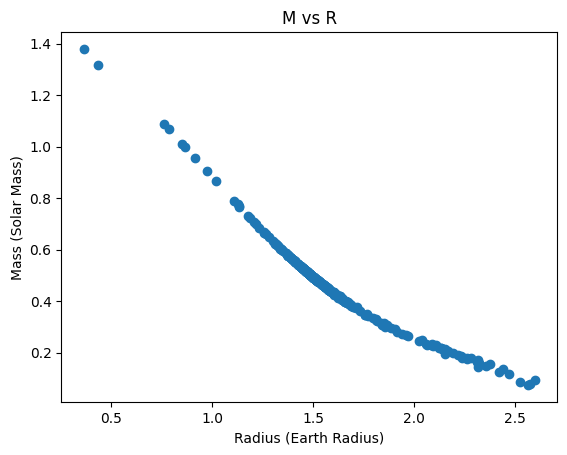

####################### PART C #########################


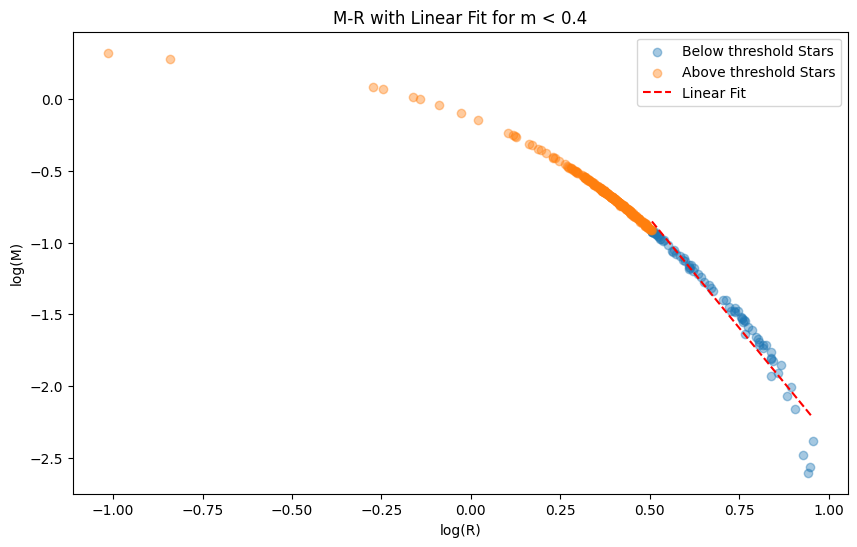

Calculated slope: -3.040


C:\Users\omerr\AppData\Local\Temp\ipykernel_8100\2280816394.py:17: RuntimeWarning: invalid value encountered in float_power
  f[1] = -np.float_power(y[0], nstar) - (2/t) * y[1]


xi_final: 3.654
theta_prime_final: -0.203
The K* value (scaled): 2.735e-01
The K* value (MKS): 2.849e+06


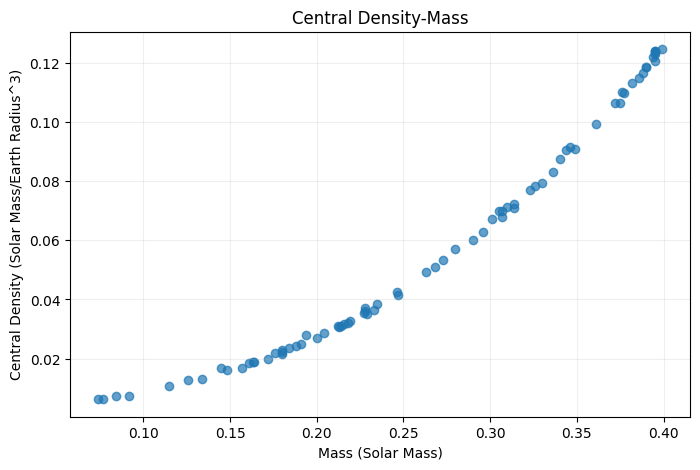

In [9]:
my_tests_newton()